In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [3]:
!pip install -q mlflow
!pip install -q python-dotenv

In [4]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [5]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [7]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2024.pkl'))

In [8]:
df.head()

,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,FG%,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [9]:
cols_tot_rank = [col for col in df.columns if '_tot' in col or '_rank' in col]
cols_to_drop = ['G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos', 'Age', 'G', 'GS', 'FGA_pg', 'FG%', '3P_pg', '3PA_pg', '3P%', '2PA_pg', '2P%', 'eFG%', 'FT%', 'ORB_pg', 'DRB_pg', 'PF_pg', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'OBPM', 'DBPM']
cols_to_drop += cols_tot_rank
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']

In [10]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('AdjustColumns', prep.AdjustCols(cols_to_adjust = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [11]:
df = pipe_clean.fit_transform(df)

In [12]:
df.head()

,,MP_pg,FG_pg,2P_pg,FT_pg,FTA_pg,TRB_pg,AST_pg,STL_pg,BLK_pg,TOV_pg,...,USG%,OWS,DWS,WS,WS/48,BPM,VORP,%W,%G,Share
Player,Season,,,,,,,,,,,,,,,,,,,,,
Kareem Abdul-Jabbar,1982,35.2,9.9,9.9,4.1,5.8,8.7,3.0,0.8,2.7,3.0,...,0.256,6.9,3.9,10.7,0.192,5.0,4.7,0.695,0.927,0.045
Alvan Adams,1982,30.3,6.4,6.4,2.3,2.9,7.4,4.5,1.4,1.0,2.5,...,0.228,2.5,4.7,7.2,0.144,3.6,3.4,0.561,0.963,0.000
Mark Aguirre,1982,28.8,7.5,7.0,3.3,4.8,4.9,3.2,0.7,0.4,2.6,...,0.298,1.0,0.8,1.9,0.061,0.7,1.0,0.341,0.622,0.000
Danny Ainge,1982,10.6,1.5,1.4,1.1,1.2,1.1,1.6,0.7,0.1,1.0,...,0.215,-0.3,0.8,0.5,0.042,-2.7,-0.1,0.768,0.646,0.000
Tiny Archibald,1982,31.9,4.5,4.4,3.5,4.6,1.7,8.0,0.8,0.0,2.6,...,0.179,3.4,1.8,5.2,0.115,0.1,1.1,0.768,0.829,0.000


In [13]:
len(df[df.index.get_level_values(1) > 2017]) / len(df)

0.20560102029971303

In [14]:
val_df = df[df.index.get_level_values(1) > 2017]
dev_df = df[df.index.get_level_values(1) <= 2017]

In [15]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [16]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20098 entries, 0 to 20097
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MP_pg   20098 non-null  float64
 1   FG_pg   20098 non-null  float64
 2   2P_pg   20098 non-null  float64
 3   FT_pg   20098 non-null  float64
 4   FTA_pg  20098 non-null  float64
 5   TRB_pg  20098 non-null  float64
 6   AST_pg  20098 non-null  float64
 7   STL_pg  20098 non-null  float64
 8   BLK_pg  20098 non-null  float64
 9   TOV_pg  20098 non-null  float64
 10  PTS_pg  20098 non-null  float64
 11  %GS     20098 non-null  float64
 12  Season  20098 non-null  int64  
 13  PER     20098 non-null  float64
 14  USG%    20098 non-null  float64
 15  OWS     20098 non-null  float64
 16  DWS     20098 non-null  float64
 17  WS      20098 non-null  float64
 18  WS/48   20098 non-null  float64
 19  BPM     20098 non-null  float64
 20  VORP    20098 non-null  float64
 21  %W      20098 non-null  float64
 22

In [18]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [19]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [20]:
# pipe_scale = Pipeline(steps = [
#     ('Scaler', scaler),
#     ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
# ])

In [21]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [22]:
mlflow.set_experiment('LightGBM v2')

<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/9', creation_time=1732911721100, experiment_id='9', last_update_time=1732911721100, lifecycle_stage='active', name='LightGBM v2', tags={}>

In [23]:
param_grid = {
    'num_leaves': [50, 30],
    'n_estimators': [130, 100],
    'learning_rate': [.5, .7],
    'min_child_samples': [10, 5],
    'max_depth': [3, 2]
    }

In [24]:
with mlflow.start_run():
    estimator = LGBMRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_lgbm(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances_lgbm(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val']))

Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

2024/12/13 22:59:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run redolent-fox-614 at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/9/runs/6ceb95f475a149048008474deffbb066
🧪 View experiment at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/9


In [25]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.010666,0.015579,0.029695
R2,0.995416,0.960471,0.707532


In [26]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

In [27]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Share,PredShare
Player,Season,,
James Harden,2018,0.955,0.888121
LeBron James,2018,0.731,0.525701
Anthony Davis,2018,0.441,0.194741
Damian Lillard,2018,0.205,0.108989
Russell Westbrook,2018,0.075,0.273784
Giannis Antetokounmpo,2018,0.074,-0.019924
Kevin Durant,2018,0.065,0.155323
DeMar DeRozan,2018,0.032,-0.012211
LaMarcus Aldridge,2018,0.006,0.243450


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2019,0.932,0.906558
James Harden,2019,0.768,1.037077
Paul George,2019,0.352,0.097018
Nikola Jokić,2019,0.210,0.168715
Stephen Curry,2019,0.173,0.154057
Damian Lillard,2019,0.068,0.039943
Joel Embiid,2019,0.049,0.213407
Kevin Durant,2019,0.025,0.232614
Kawhi Leonard,2019,0.013,0.187142


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2020,0.952,0.512168
LeBron James,2020,0.746,0.226581
James Harden,2020,0.363,0.751592
Luka Dončić,2020,0.198,0.311543
Kawhi Leonard,2020,0.166,0.150867
Anthony Davis,2020,0.081,0.195959
Chris Paul,2020,0.026,0.001187
Damian Lillard,2020,0.023,0.097687
Nikola Jokić,2020,0.018,0.108520


,,Share,PredShare
Player,Season,,
Nikola Jokić,2021,0.961,0.522602
Joel Embiid,2021,0.580,0.382645
Stephen Curry,2021,0.449,0.142487
Giannis Antetokounmpo,2021,0.345,-0.013139
Chris Paul,2021,0.138,-0.000984
Luka Dončić,2021,0.042,0.314697
Damian Lillard,2021,0.038,0.199488
Julius Randle,2021,0.020,0.032968
Derrick Rose,2021,0.010,-0.001021


,,Share,PredShare
Player,Season,,
Nikola Jokić,2022,0.875,0.566531
Joel Embiid,2022,0.706,0.929535
Giannis Antetokounmpo,2022,0.595,0.588752
Devin Booker,2022,0.216,0.141431
Luka Dončić,2022,0.146,0.374680
Jayson Tatum,2022,0.043,0.075004
Ja Morant,2022,0.010,0.207799
Stephen Curry,2022,0.004,-0.026466
Chris Paul,2022,0.002,-0.007228


,,Share,PredShare
Player,Season,,
Joel Embiid,2023,0.915,0.808235
Nikola Jokić,2023,0.674,0.577494
Giannis Antetokounmpo,2023,0.606,0.540463
Jayson Tatum,2023,0.280,0.276288
Shai Gilgeous-Alexander,2023,0.046,-0.036823
Donovan Mitchell,2023,0.030,0.075778
Domantas Sabonis,2023,0.027,0.043941
Luka Dončić,2023,0.010,0.007495
Stephen Curry,2023,0.005,-0.045434


,,Share,PredShare
Player,Season,,
Nikola Jokić,2024,0.935,0.920772
Shai Gilgeous-Alexander,2024,0.646,0.513575
Luka Dončić,2024,0.572,0.728166
Giannis Antetokounmpo,2024,0.194,0.497746
Jalen Brunson,2024,0.143,-0.011861
Jayson Tatum,2024,0.087,0.272518
Anthony Edwards,2024,0.018,0.215329
Domantas Sabonis,2024,0.003,0.119384
Kevin Durant,2024,0.001,0.048632


No contenders results:


,,Share,PredShare
Player,Season,,
Bradley Beal,2018,0.0,0.000707
Michael Beasley,2018,0.0,0.000259
Anthony Brown,2018,0.0,0.001914
Clint Capela,2018,0.0,0.007001
Darren Collison,2018,0.0,0.003598
...,...,...,...
Markquis Nowell,2024,0.0,0.002043
Leonard Miller,2024,0.0,0.004237
Josh Minott,2024,0.0,0.002849


In [28]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Share,PredShare
Player,Season,,
DeMarcus Cousins,2018,0.0,0.121166
Andre Drummond,2020,0.0,0.170954
Elijah Bryant,2021,0.0,0.116024
Jimmy Butler,2021,0.0,0.212080
Kevin Durant,2021,0.0,0.118884
Donovan Mitchell,2021,0.0,0.150189
Jaylen Brown,2023,0.0,0.124360
Tyrese Haliburton,2023,0.0,0.129779
Joel Embiid,2024,0.0,0.448112


<Axes: title={'center': 'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

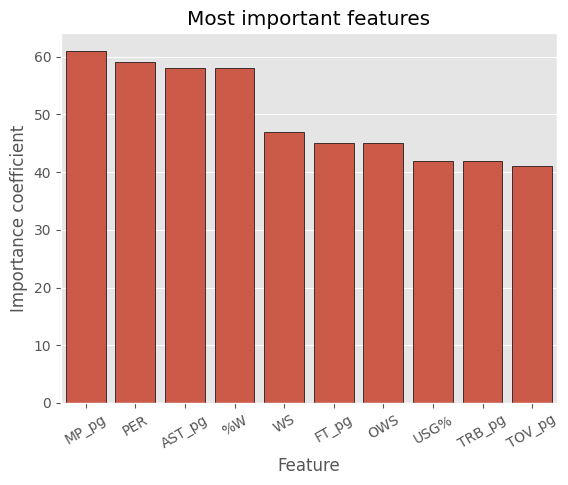

In [29]:
mod.display_feature_importances_lgbm(best_model)

In [30]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

(<Figure size 4000x4000 with 8 Axes>, <Figure size 4000x4000 with 8 Axes>)

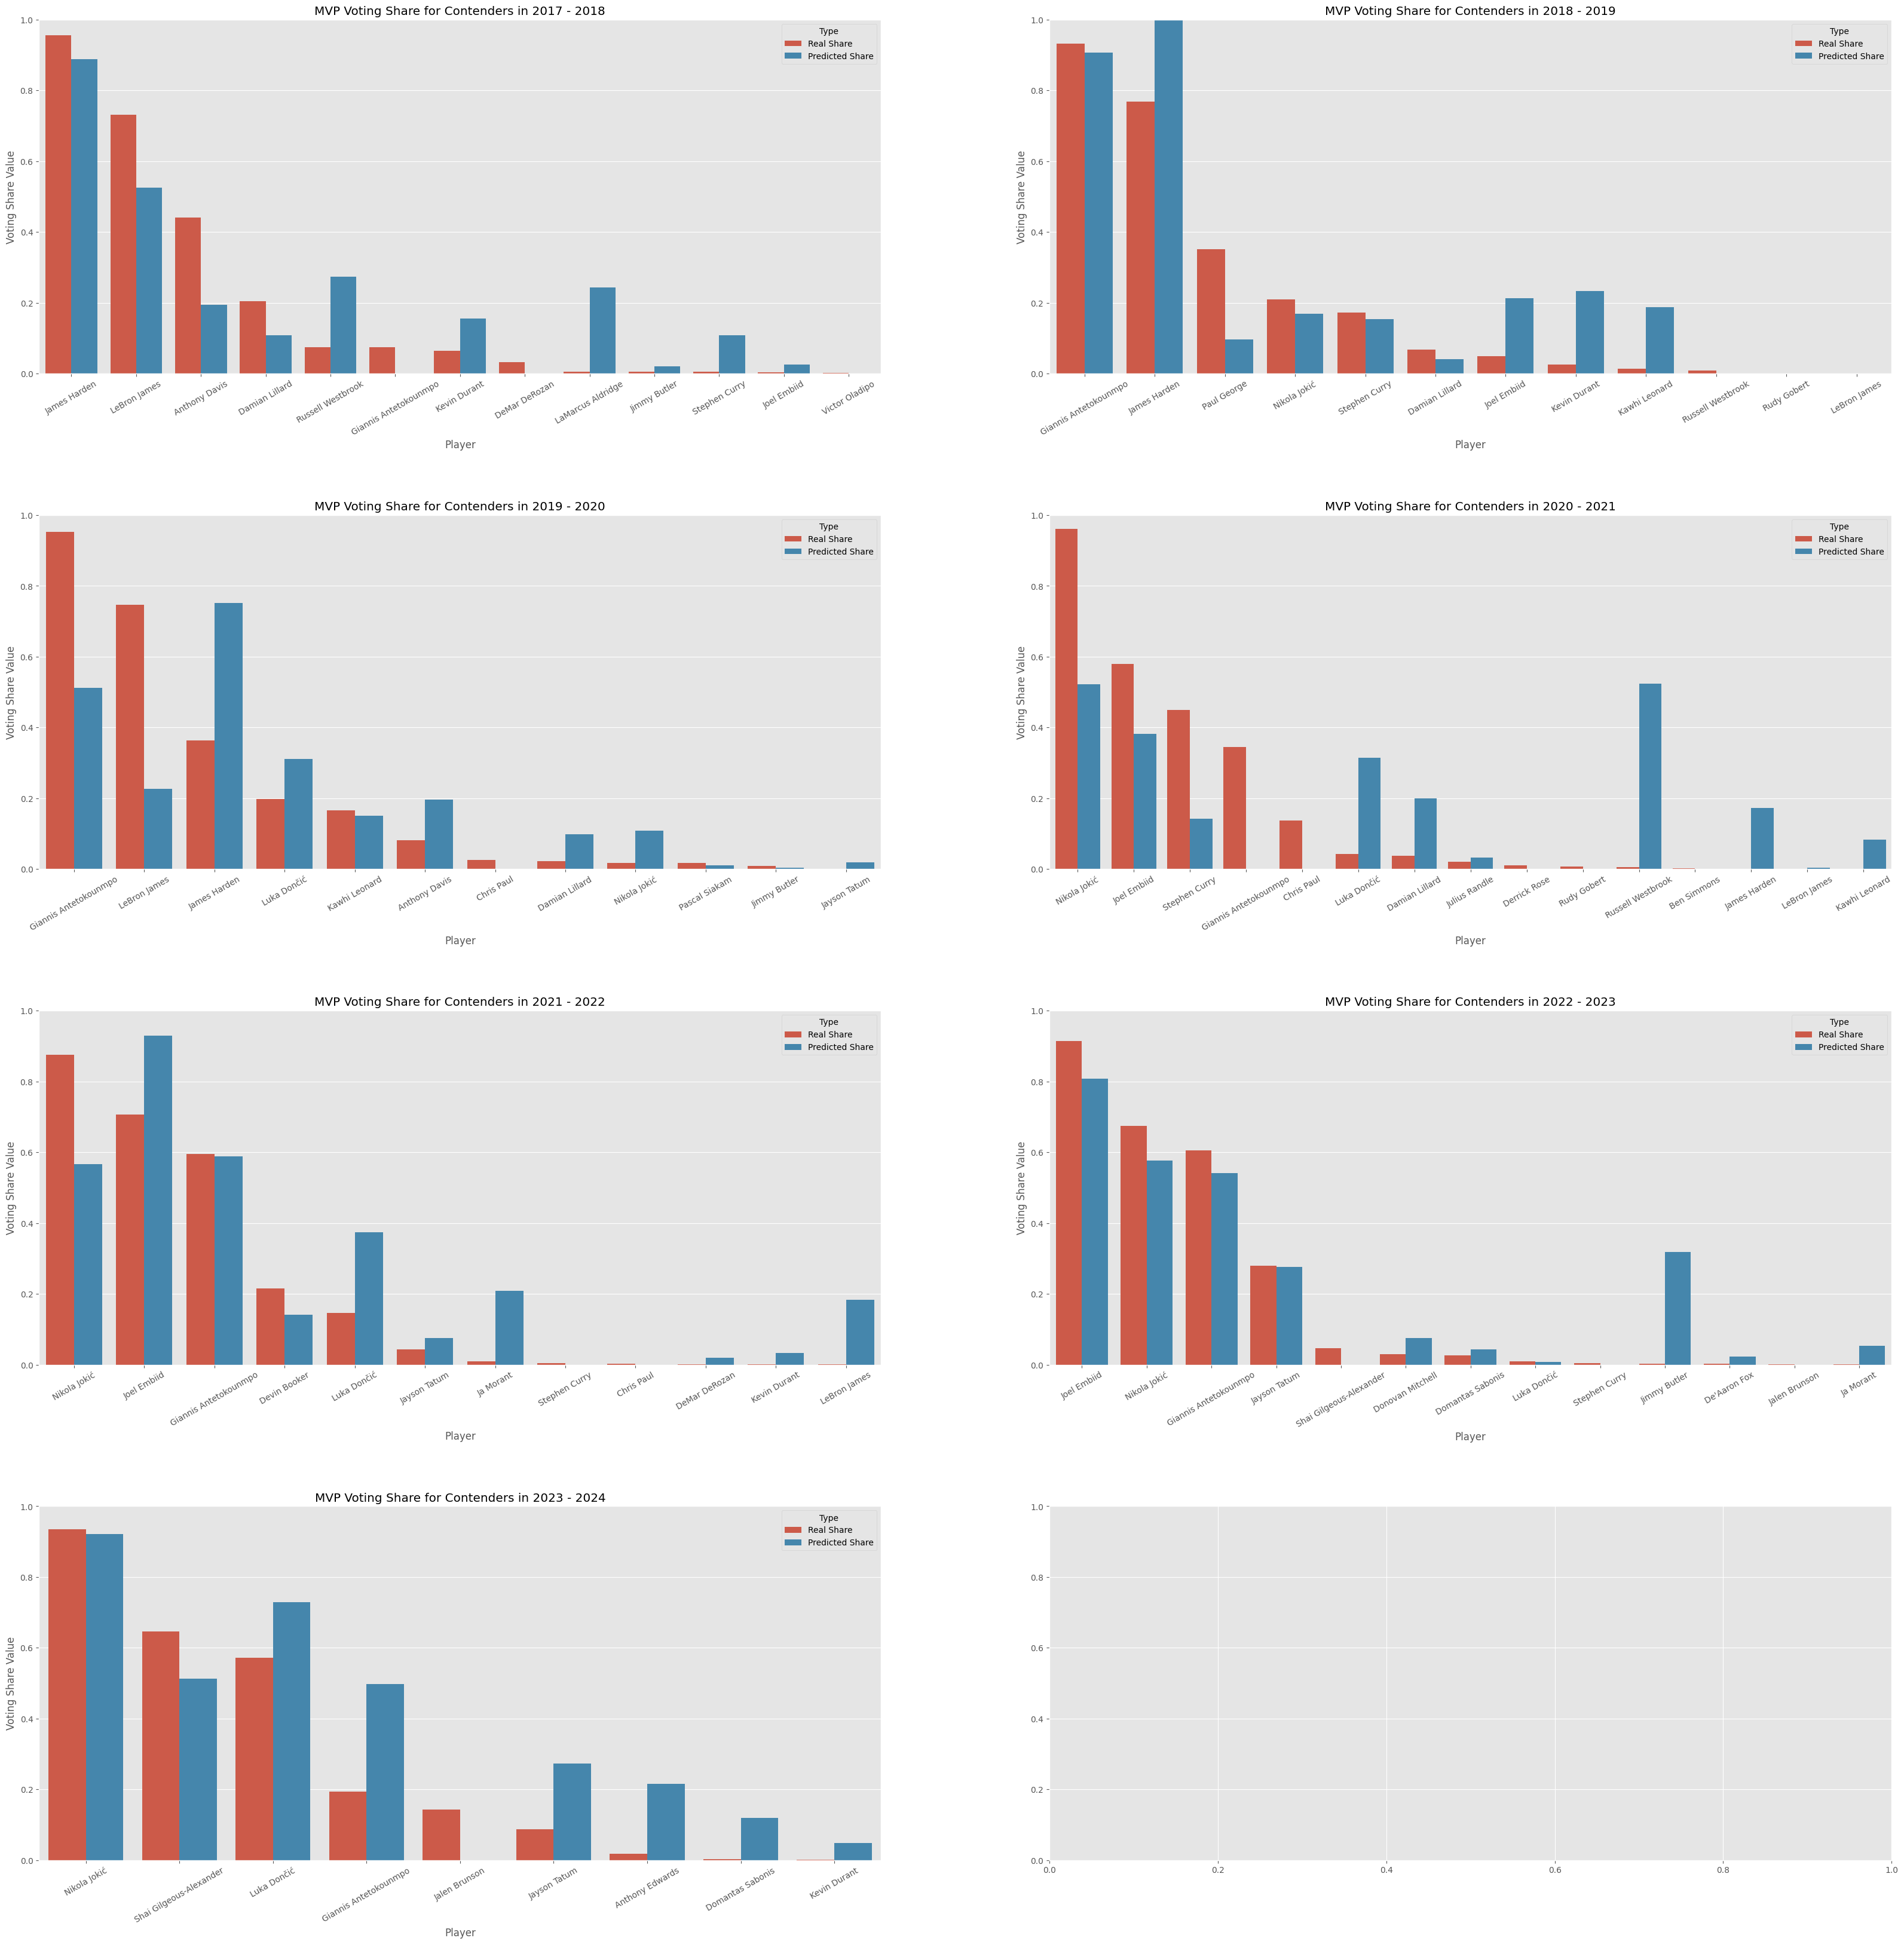

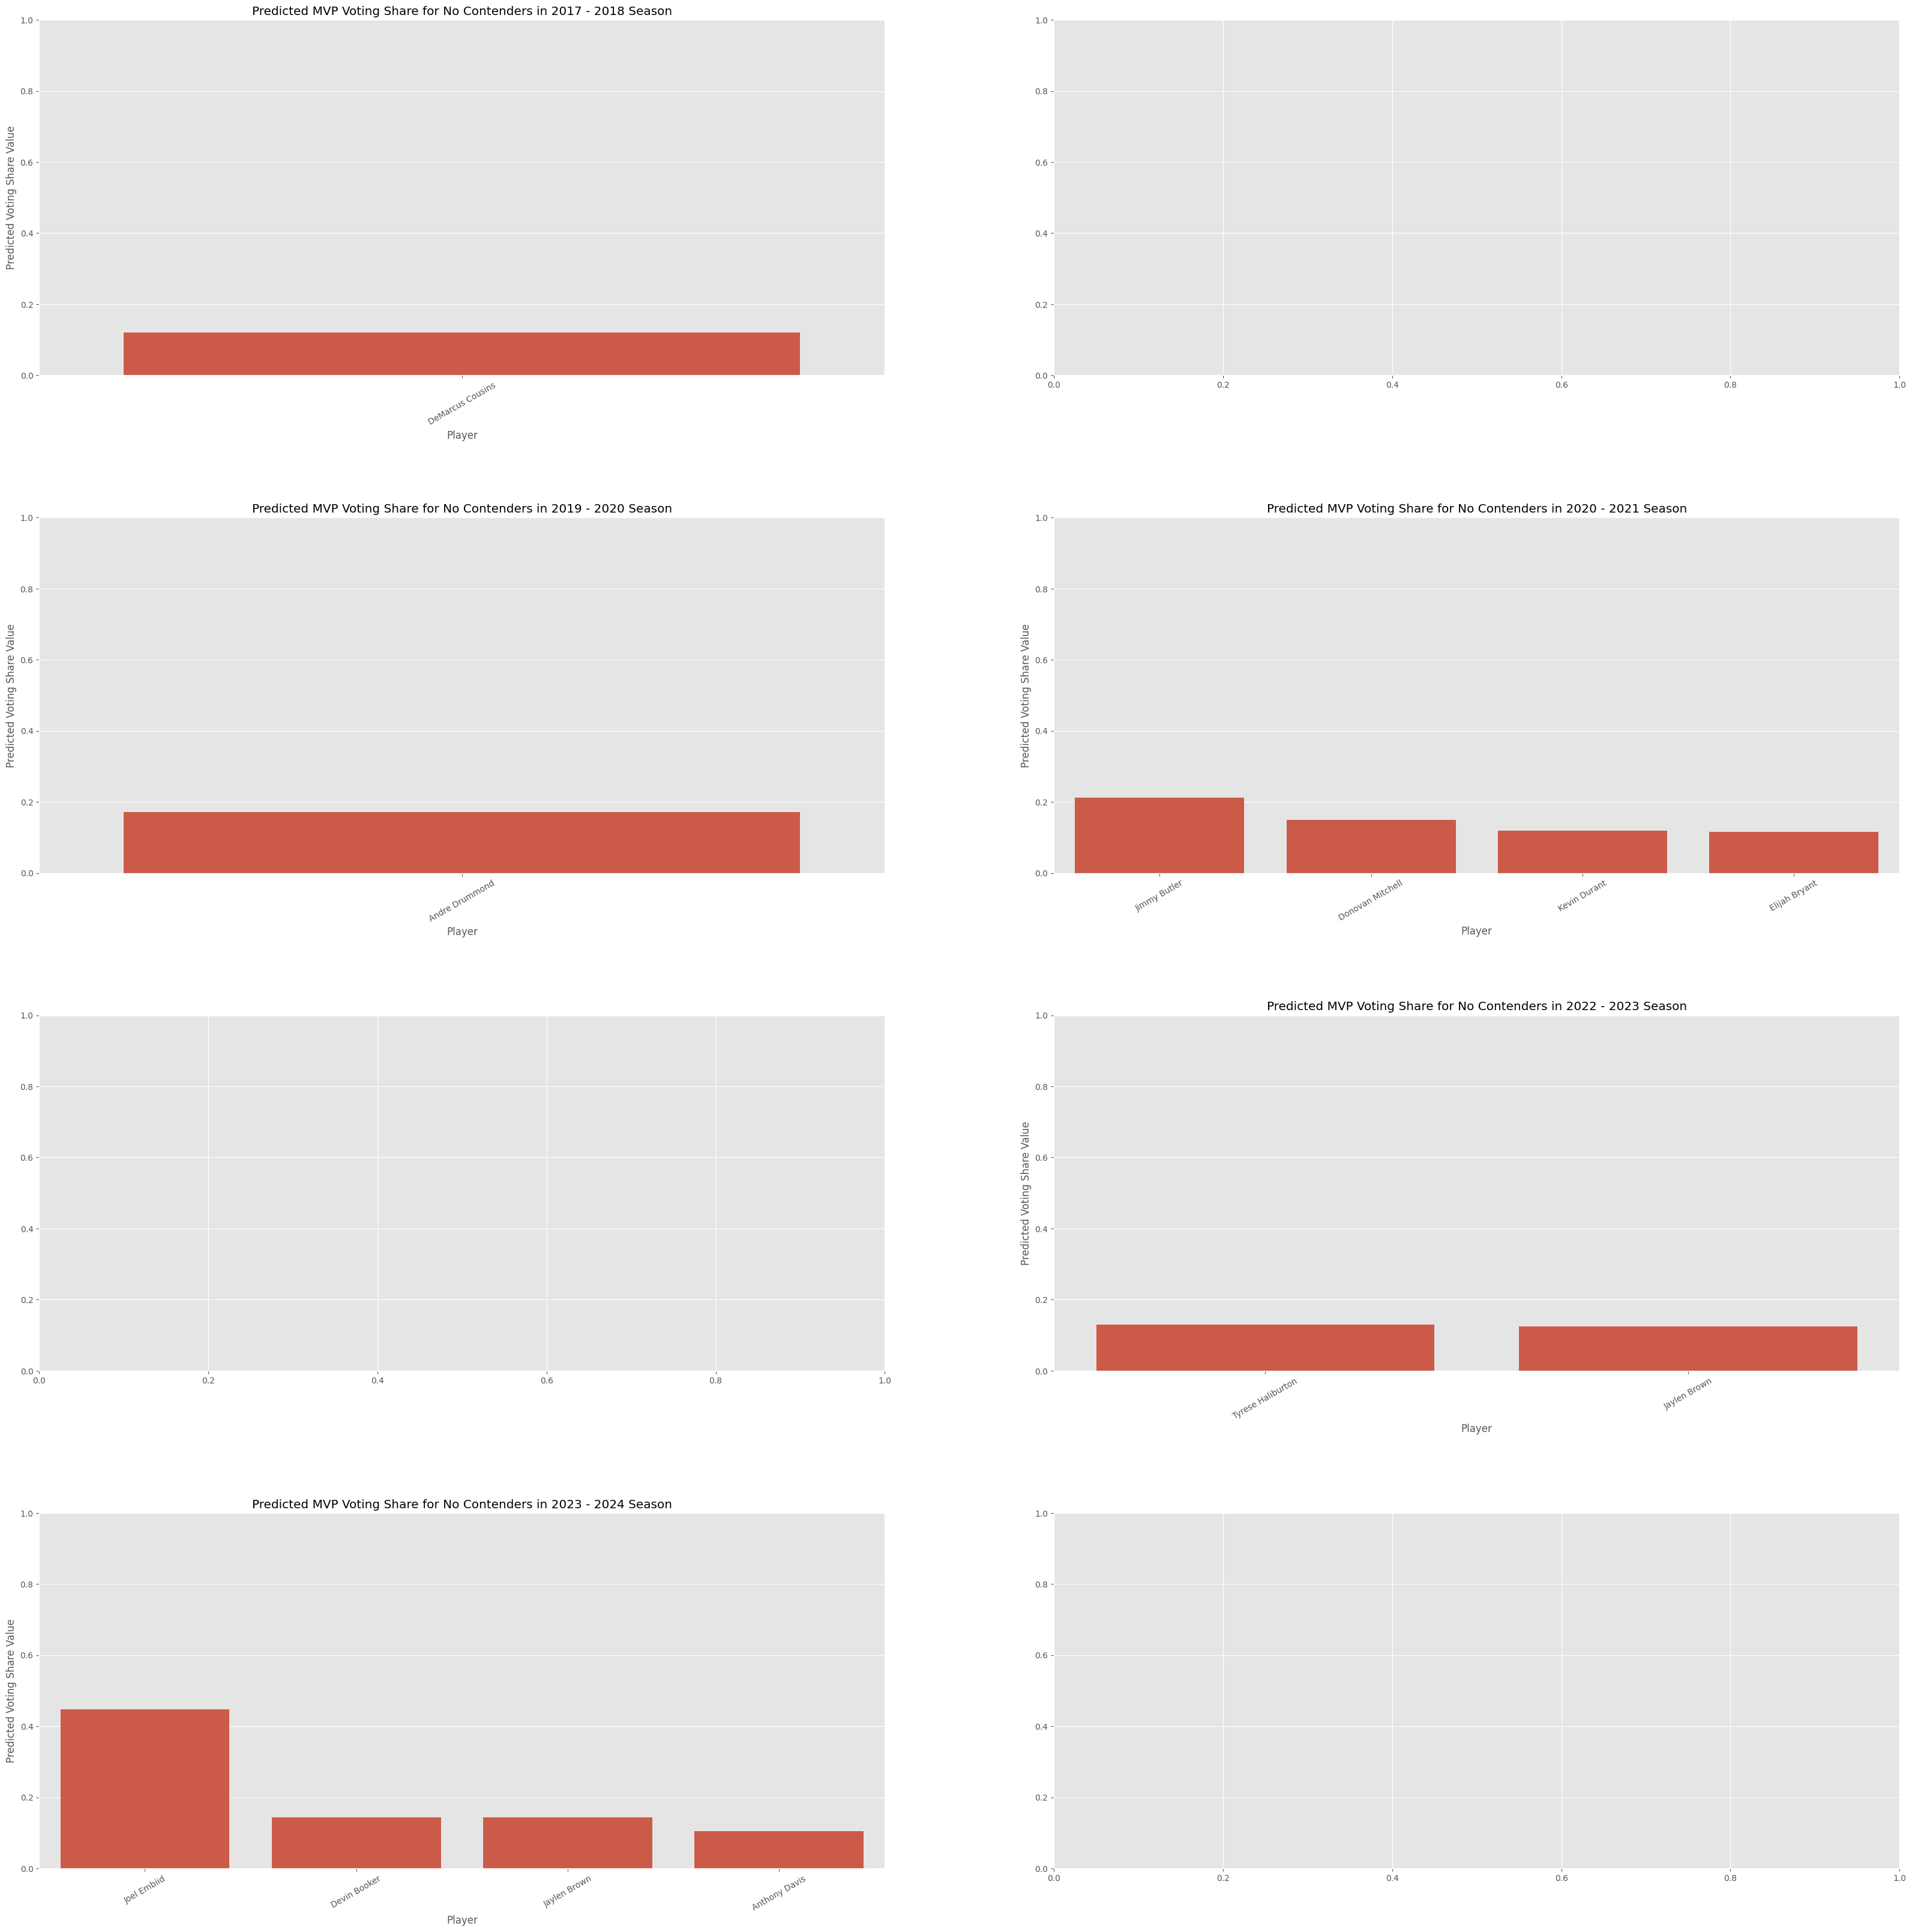

In [31]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'])